# MRI and Alzheimers 
## Predict Dementia Using Longitudinal MRI Data in Nondemented and Demented Older Adults 
### Huiyu (Shirley) Sun 
##### May 9, 2019

## Import Dataset

#### Data Features (151 subjects)
- Subject ID
- MRI ID
- Visit
- MR Delay
###### Demographic
- M/F
- Hand - Right hand
- Age - (60 - 98)
- EDUC (years)
- SES - Socioeconomic status 1: less than high school grad., 2: high school grad., 3: some college, 4: college grad., 5: beyond college.
###### Clinical
- MMSE - Mini-Mental State Examination
- CDR - Clinical Dementia Rating (CDR; 0 = nondemented; 0.5 = very mild dementia; 1 = mild dementia; 2 = moderate dementia) (Morris, 1993). All participants with dementia (CDR >0) were diagnosed with probable AD.
###### Derived anatomic volumes
- eTIV - Estimated total intracranial volume
- nWBV - Normalized whole brain volume
- ASF - Atlas scaling factor
###### Response to be predicted
- Group - Demented, Nondemented, Converted

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mri_long = pd.read_csv('oasis_longitudinal.csv', sep = ',')
mri_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
# closer look to the score and labels
mri_long.groupby(['CDR', 'Group']).size().unstack()

Group,Converted,Demented,Nondemented
CDR,,,
0.0,18.0,NaN,188.0
0.5,19.0,102.0,2.0
1.0,NaN,41.0,NaN
2.0,NaN,3.0,NaN


In [3]:
mri_long.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

## Pre-Process

In [4]:
df = mri_long
df = df.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1)
display(df.head(), df.shape)

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


(373, 12)

In [5]:
df.isnull().sum()

Group        0
Visit        0
MR Delay     0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

In [7]:
# MMSE Scores Mini-Mental State Examination - Ordinal
# Ref: https://www.heartandstroke.ca/-/media/pdf-files/canada/clinical-update/allen-huang-cognitive-screening-toolkit.ashx?la=en&hash=631B35521724C28268D0C2130D07A401E33CDBB0
# 25-30 (Questionably significant); 20-25 (Mild); 10-20 (Moderate); 0-10 (Severe)
def mmse_group(col):
    if col <= 10:
        return "Severe"
    elif 10 < col <= 20:
        return "Moderate"
    elif 20 < col <= 25:
        return "Mild"
    elif 25 < col <= 30:
        return "Questionably significant"
    else:
        return "missing"

def mmse_code(col):
    if col <= 10:
        return "3"
    elif 10 < col <= 20:
        return "2"
    elif 20 < col <= 25:
        return "1"
    elif 25 < col <= 30:
        return "0"
    else:
        return "-1"
df['MMSE Group'] = df['MMSE'].apply(mmse_group)
df['MMSE Group'].value_counts(sort = True)

df['MMSE_code'] = df['MMSE'].apply(mmse_code)
df.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_code,MMSE Group,MMSE_code
0,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,Questionably significant,0
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876,0,Questionably significant,0
2,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046,1,Mild,1
3,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010,1,Questionably significant,0
4,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034,1,Mild,1


In [8]:
from sklearn.preprocessing import LabelEncoder

# 0.0 (0), 0.5 (1), 1 (2)
df['CDR_code']= LabelEncoder().fit_transform(df['CDR'])

# M/F F = 0, M = 1
df['Gender_code'] = LabelEncoder().fit_transform(df['M/F'])

# Group Demented = 0, Nondemented = 1
# df['Group'] = df['Group'].replace(['Converted'],['Demented'])
# df['Group_code'] = LabelEncoder().fit_transform(df['Group'])


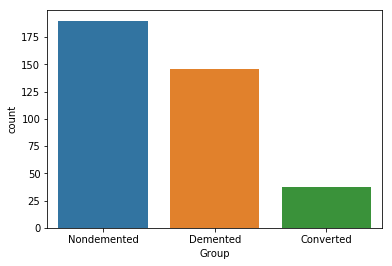

In [9]:
# Demented > ND at patients' initial visit
sns.countplot(x = 'Group', data = df)

In [10]:
# Group Demented = 0, Nondemented = 1
df['Group'] = df['Group'].replace(['Converted'],['Demented'])
df['Group_code'] = LabelEncoder().fit_transform(df['Group'])

df[['M/F', 'Gender_code', 'Group', 'Group_code']].head()

,M/F,Gender_code,Group,Group_code
0,M,1,Nondemented,1
1,M,1,Nondemented,1
2,M,1,Demented,0
3,M,1,Demented,0
4,M,1,Demented,0


In [11]:
display(df.info(), df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 17 columns):
Group          373 non-null object
Visit          373 non-null int64
MR Delay       373 non-null int64
M/F            373 non-null object
Age            373 non-null int64
EDUC           373 non-null int64
SES            354 non-null float64
MMSE           371 non-null float64
CDR            373 non-null float64
eTIV           373 non-null int64
nWBV           373 non-null float64
ASF            373 non-null float64
CDR_code       373 non-null int64
MMSE Group     373 non-null object
MMSE_code      373 non-null object
Gender_code    373 non-null int64
Group_code     373 non-null int64
dtypes: float64(5), int64(8), object(4)
memory usage: 49.6+ KB


None

Index(['Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE',
       'CDR', 'eTIV', 'nWBV', 'ASF', 'CDR_code', 'MMSE Group', 'MMSE_code',
       'Gender_code', 'Group_code'],
      dtype='object')

## Data Exploration

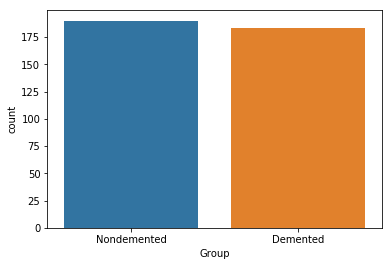

In [12]:
# converted --> Demented
sns.countplot(x = 'Group', data = df)

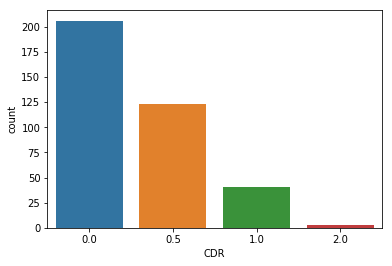

In [13]:
sns.countplot(x = 'CDR', data= df)

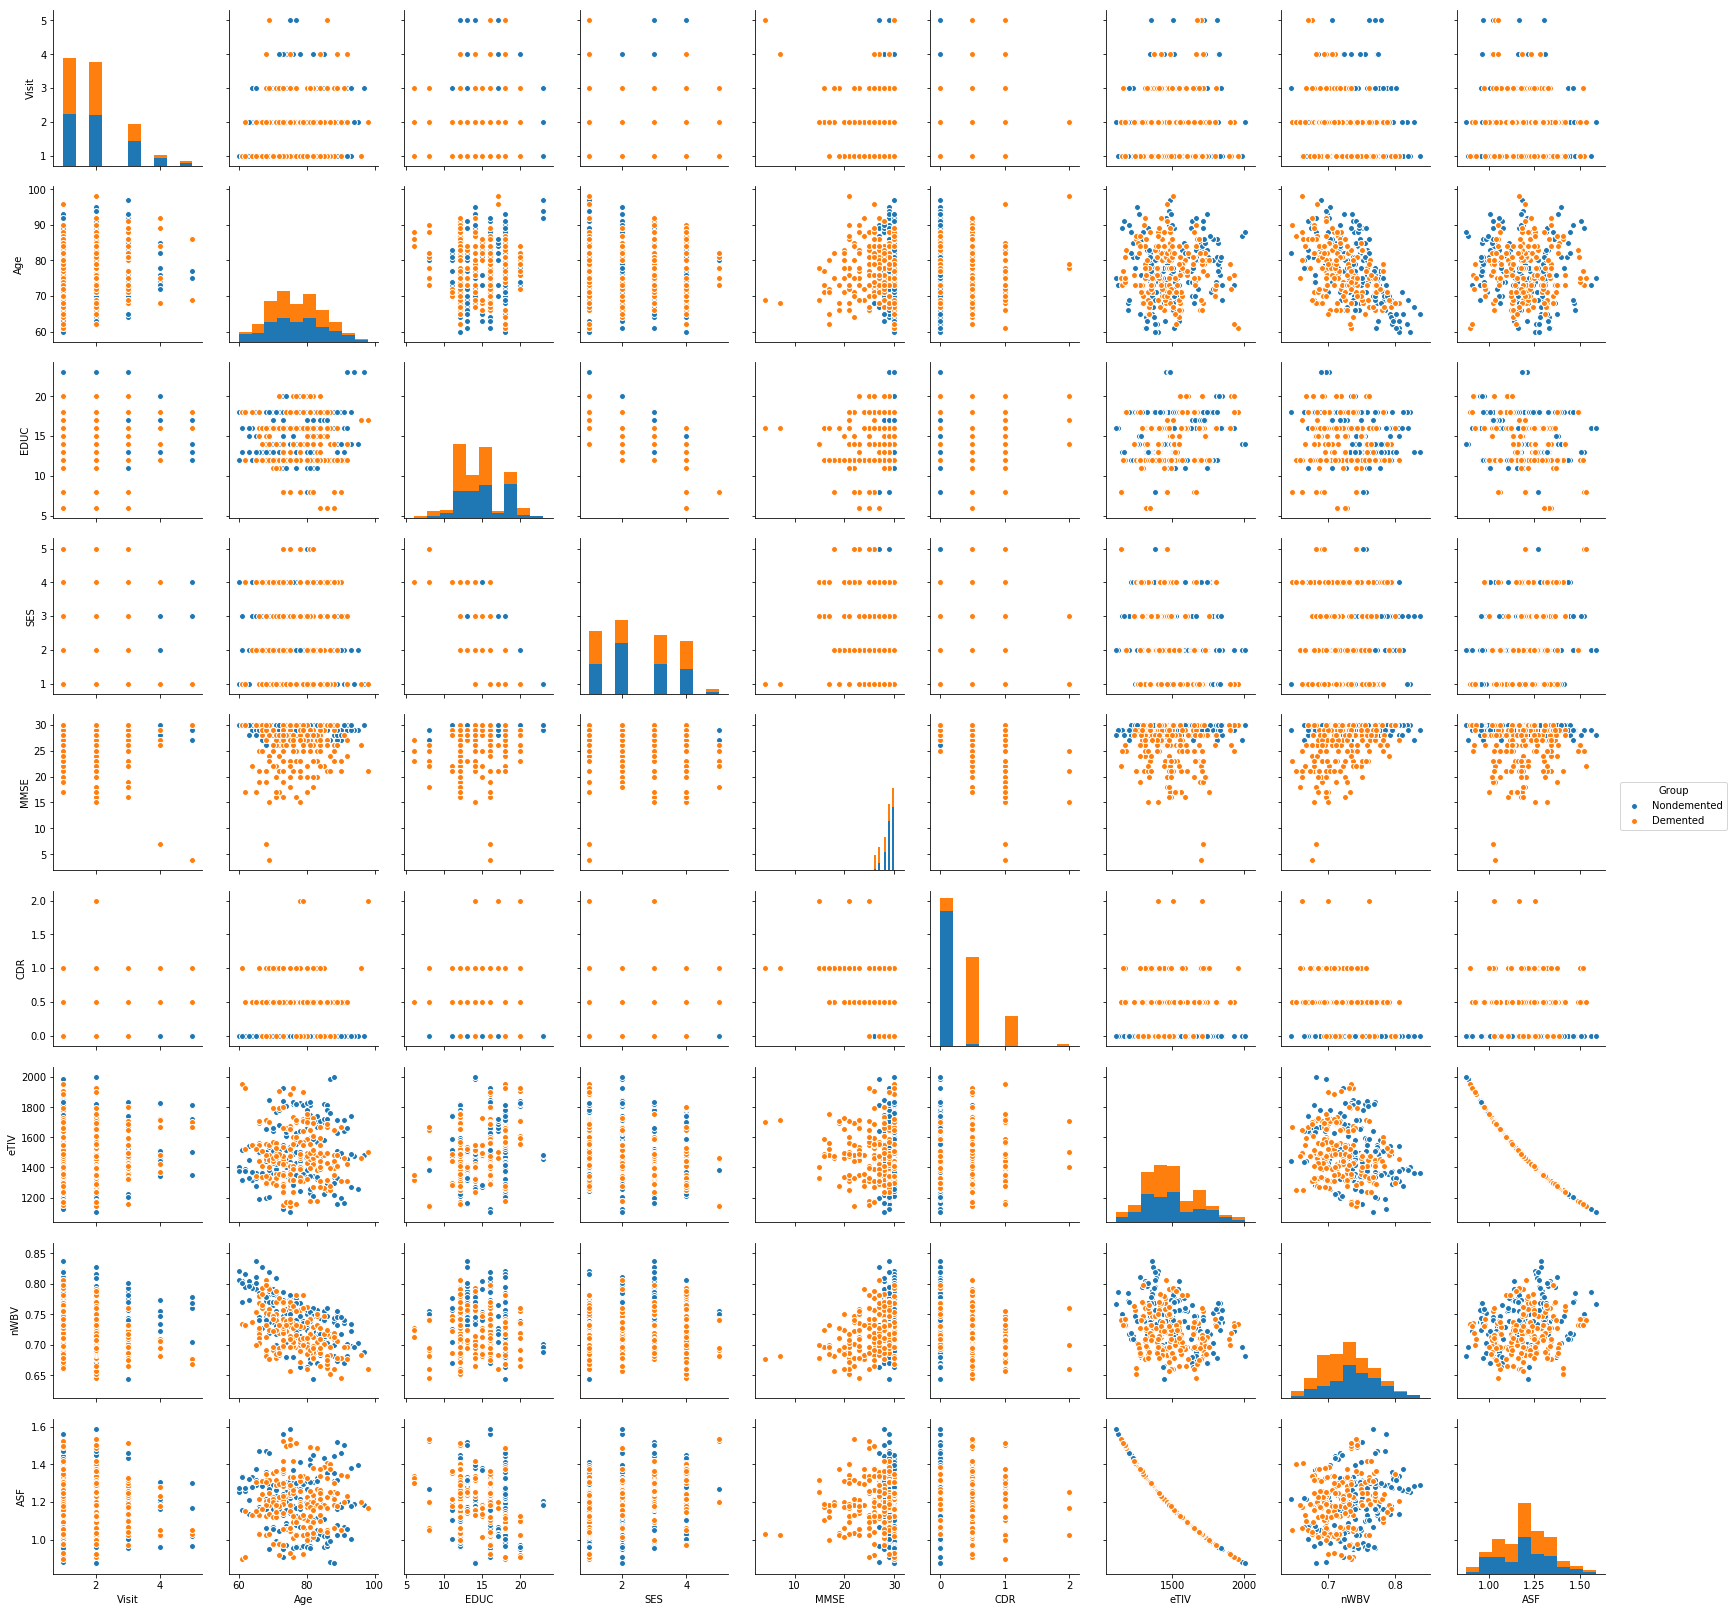

In [14]:
# multicolinearity exists
cols1 = ['Group', 'M/F', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV','ASF']
df1 = df[cols1]
sns.pairplot(df1, hue = 'Group')

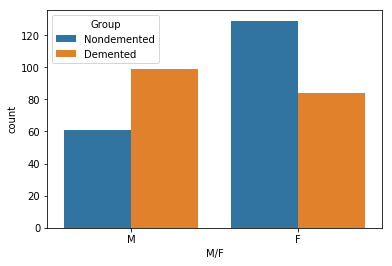

In [15]:
# Gender: M/F
# Demented male > ND male ; ND female > Demented female
# female less likely to be Demented than male
sns.countplot(x = 'M/F', hue = 'Group', data = df)

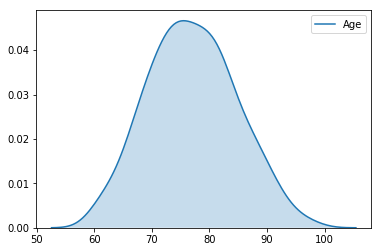

In [16]:
# Age vs Group
sns.kdeplot(df['Age'], shade = True)

### Remove NA & Impute

In [17]:
# remove NA
df_rmna = df.dropna()

### Normalization

In [18]:
# recoded categorical varibles (Group_code)
# Group, M/F nominal
# CDR ordinal
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE_code', 'CDR_code', 'eTIV', 'nWBV', 'ASF', 'MR Delay']
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR_code', 'eTIV', 'nWBV', 'ASF', 'MR Delay']
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'MR Delay']

X = df_rmna[x_cols]
y = df_rmna['Group_code'].astype('category')

## Modeling
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- KNN

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X, y
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'MR Delay']
X = df_rmna[x_cols]
y = df_rmna['Group_code'].astype('category')

# Training & Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

num_cols = ['Visit', 'Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'ASF', 'MMSE']

# normalization
# training set
X_train_norm = StandardScaler().fit_transform(X_train[num_cols])
training_norm_col = pd.DataFrame(X_train_norm, index = X_train[num_cols].index, columns = X_train[num_cols].columns)
X_train.update(training_norm_col)

# test set
X_test_norm = StandardScaler().fit_transform(X_test[num_cols])
test_norm_col = pd.DataFrame(X_test_norm, index = X_test[num_cols].index, columns = X_test[num_cols].columns)
X_test.update(test_norm_col)

# whole set
X_norm = StandardScaler().fit_transform(X[num_cols])
norm_col = pd.DataFrame(X_norm, index = X[num_cols].index, columns = X[num_cols].columns)
X.update(norm_col)


X_train.shape, y_train.shape

C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5082: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


((237, 10), (237,))

In [20]:
X_test.head()

,Gender_code,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,MR Delay
230,1,0.149565,0.800776,-1.230392,1.466054,0.414624,1.484825,-1.611983,-1.388051,766
48,0,0.149565,-0.776068,-0.897930,0.533835,0.693423,-0.705987,1.487111,0.660120,609
298,0,0.149565,-0.513260,0.431916,0.533835,0.414624,-1.122469,1.182735,1.184739,1707
189,1,-0.944131,-0.513260,1.096839,-0.398384,0.414624,0.366598,1.238076,-0.468171,0
62,0,-0.944131,0.275161,0.431916,-1.330603,0.414624,-0.101231,-0.698857,-0.015417,0


In [21]:
X_test.shape, y_test.shape

((117, 10), (117,))

In [22]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

se_lr = np.round(mean_squared_error(y_test, y_predict),2)
acc_lr = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_lr)
print('Accuracy:', acc_lr)

MSE: 0.17
Accuracy: 0.83


In [23]:
# Logistic Regression CV
lr.fit(X, y)
y_predict = lr.predict(X)

cv = KFold(n_splits=5, shuffle=True, random_state=10)
se = abs(np.mean(cross_val_score(lr, X, y, cv=cv, scoring="neg_mean_squared_error")))
acc = abs(np.mean(cross_val_score(lr, X, y, cv=cv, scoring="accuracy")))
print('MSE: ', np.round(se, 2))
print('Accuracy: ', np.round(acc, 2))

MSE:  0.23
Accuracy:  0.77


MSE: 0.24
Accuracy: 0.76


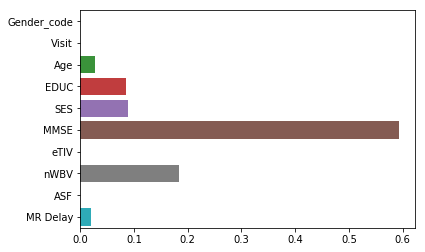

In [24]:
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier(max_depth = 5, random_state = 0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)

se_dtr = np.round(mean_squared_error(y_test, y_predict),2)
acc_dtr = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_dtr)
print('Accuracy:', acc_dtr)

fea_ip = dtr.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [25]:
# Decision Tree CV
dtr.fit(X, y)

cv = KFold(n_splits=5, shuffle=True, random_state=10)
se = abs(np.mean(cross_val_score(dtr, X, y, cv=cv, scoring="neg_mean_squared_error")))
acc = abs(np.mean(cross_val_score(dtr, X, y, cv=cv, scoring="accuracy")))

print('MSE: ', np.round(se, 2))
print('Accuracy: ', np.round(acc, 2))

MSE:  0.23
Accuracy:  0.77


MSE: 0.21
Accuracy: 0.79


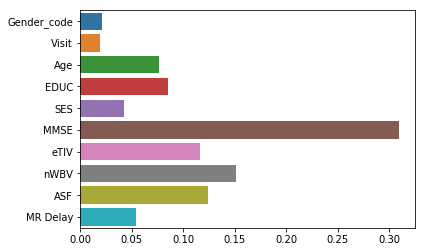

In [26]:
# Random Forest (bagging)
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = 123)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
mean_squared_error(y_test, y_predict)

se_rf = np.round(mean_squared_error(y_test, y_predict),2)
acc_rf = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_rf)
print('Accuracy:', acc_rf)

fea_ip = rf.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [27]:
# Random Forest CV
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=10)
se = abs(np.mean(cross_val_score(rf, X, y, cv=cv, scoring="neg_mean_squared_error")))
acc = abs(np.mean(cross_val_score(rf, X, y, cv=cv, scoring="accuracy")))

print('MSE: ', np.round(se, 2))
print('Accuracy: ', np.round(acc, 2))

MSE:  0.19
Accuracy:  0.81


MSE: 0.18
Accuracy: 0.82


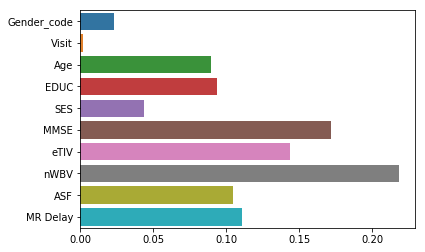

In [28]:
# Gradient Boosting (boosting)
# sequential improvement of models by training on their errors
# improves errors, one tree each step
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = 0)
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
mean_squared_error(y_test, y_predict)

se_gb = np.round(mean_squared_error(y_test, y_predict),2)
acc_gb = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_gb)
print('Accuracy:', acc_gb)

fea_ip = gb.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [29]:
# Gradient Boosting CV
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=10)
se = abs(np.mean(cross_val_score(gb, X, y, cv=cv, scoring="neg_mean_squared_error")))
acc = abs(np.mean(cross_val_score(gb, X, y, cv=cv, scoring="accuracy")))

print('MSE: ', np.round(se, 2))
print('Accuracy: ', np.round(acc, 2))

MSE:  0.17
Accuracy:  0.83


In [30]:
# SVM
from sklearn.svm import SVC

clf = SVC(gamma='auto', random_state = 123)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

se_clf = np.round(mean_squared_error(y_test, y_predict),2)
acc_clf = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_clf)
print('Accuracy:', acc_clf)

MSE: 0.43
Accuracy: 0.57


In [31]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

y_predict = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train).predict(X_test)

se_knn = np.round(mean_squared_error(y_test, y_predict),2)
acc_knn = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_knn)
print('Accuracy:', acc_knn)

MSE: 0.48
Accuracy: 0.52


Text(0.5,1,'Accuracy')

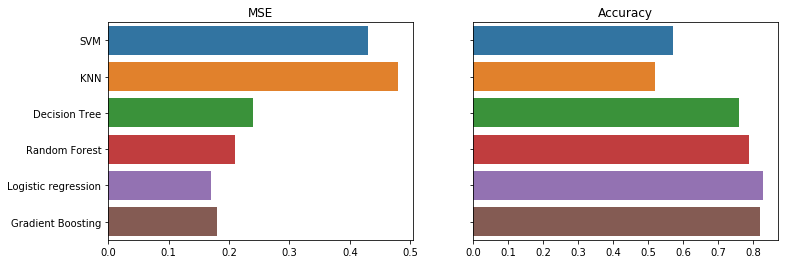

In [32]:
# visualize all methods
methods = ['SVM', 'KNN','Decision Tree', 'Random Forest', 'Logistic regression', 'Gradient Boosting']

se = [se_clf, se_knn, se_dtr, se_rf, se_lr, se_gb]
acc = [acc_clf, acc_knn, acc_dtr, acc_rf, acc_lr, acc_gb]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
sns.barplot(x = se, y = methods, ax = ax1).set_title('MSE')
sns.barplot(x = acc, y = methods, ax = ax2).set_title('Accuracy')

### Non-normalization

In [33]:
from sklearn.model_selection import train_test_split

x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

X = df_rmna[x_cols]
y = df_rmna['Group_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# logistic regression
lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
mean_squared_error(y_test, y_predict)

0.18803418803418803

In [34]:
X_train.head()

,Gender_code,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
110,1,1,74,18,2.0,29.0,1463,0.737,1.199
286,0,2,78,16,3.0,27.0,1393,0.690,1.260
124,1,2,79,14,3.0,26.0,1308,0.706,1.341
37,1,2,82,20,1.0,28.0,1606,0.677,1.093
42,0,2,64,16,3.0,29.0,1316,0.796,1.333


In [35]:
# lasso
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
llr = Lasso(alpha=0.5)
llr.fit(X, y)
preds = llr.predict(X)

# Create the CV iterator
cv = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(llr, X, y, cv=cv, scoring="neg_mean_squared_error"))) 

0.19868354761536947

In [36]:
# Ridge regression
from sklearn.linear_model import Ridge

llr = Ridge(alpha=0.5)
llr.fit(X, y)
preds = llr.predict(X)

# Create the CV iterator
cv = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(llr, X, y, cv=cv, scoring="neg_mean_squared_error")))

0.1674379036182755